In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import os

## Functions
### ROC, PR

In [2]:
def roc(test, pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(test, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
 
    print ('ROC_AUC: %.6f' %roc_auc[1])
    plt.figure()
    
    plt.plot(fpr[1], tpr[1], lw=2, label='ROC curve (area = %0.4f)' % roc_auc[1])
 
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()

    
def roc_print(test, pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(test, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
 
    return roc_auc[1]    


def pr(test, pred):
	lw =2
	from sklearn.metrics import precision_recall_curve
	from sklearn.metrics import average_precision_score
	# Compute Precision-Recall and plot curve
	precision = dict()
	recall = dict()
	average_precision = dict()
	for i in range(2):
	    precision[i], recall[i], _ = precision_recall_curve(test,
	                                                        pred)
	    average_precision[i] = average_precision_score(test, pred)

	# Compute micro-average ROC curve and ROC area
	precision["micro"], recall["micro"], _ = precision_recall_curve(test.ravel(),
	    pred.ravel())
	average_precision["micro"] = average_precision_score(test, pred,
	                                                     average="micro")


	# Plot Precision-Recall curve
	plt.clf()
	plt.plot(recall[0], precision[0], lw=lw, color='navy',
	         label='Precision-Recall curve')
	plt.xlabel('Recall')
	plt.ylabel('Precision')
	plt.ylim([0.0, 1.0])
	plt.xlim([0.0, 1.0])
	plt.title('Precision-Recall: AUC={0:0.3f}'.format(average_precision[0]))
	plt.legend(loc="lower left")
	plt.show()


### Scores 

In [ ]:

def scores(dirname, classifier):

	for filename in os.listdir(dirname):
		if filename.endswith(".vcf.csv"):
			print(filename)
			df = pd.read_csv(dirname + filename)
			df1 = df.iloc[:,1:68]
			out= list(classifier.predict_proba(x = df1))
			y_score = np.vstack(out)[:,1]
			file = open('scores/'+filename[:-8], 'w+')
			for item in y_score:
				file.write("%s\n" % item)

			file.close()
			continue
		else:
			continue

### Test file selector

In [3]:
def testfile(filename, output):
    lines = open(filename).readlines()
    open(output, 'w+').writelines(lines[1:])
    

### Main Function with 3 -layered Model

In [ ]:

def main():
    tf.logging.set_verbosity(tf.logging.INFO)

    
    training_set = tf.contrib.learn.datasets.base.load_csv_with_header (filename='tissue2_train.csv', 
        target_dtype=np.int, 
        features_dtype=np.float64, 
        target_column = 0)

    test_set = tf.contrib.learn.datasets.base.load_csv_with_header (filename='tissue2_test.csv', 
        target_dtype=np.int, 
        features_dtype=np.float64, 
        target_column = 0)

    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=80)]

    validation_metrics = {
    "accuracy":
        tf.contrib.learn.MetricSpec(
            metric_fn=tf.contrib.metrics.streaming_accuracy,
            prediction_key=tf.contrib.learn.PredictionKey.CLASSES),
    "precision":
        tf.contrib.learn.MetricSpec(
            metric_fn=tf.contrib.metrics.streaming_precision,
            prediction_key=tf.contrib.learn.PredictionKey.CLASSES),
    "recall":
        tf.contrib.learn.MetricSpec(
            metric_fn=tf.contrib.metrics.streaming_recall,
            prediction_key=tf.contrib.learn.PredictionKey.CLASSES)}


    validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
        test_set.data,
        test_set.target,
        eval_steps =1,
        every_n_steps=50,
        metrics=validation_metrics,
        early_stopping_metric="loss",
        early_stopping_metric_minimize=True,
        early_stopping_rounds=200)



    classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
        hidden_units= [200,200],
        n_classes=2,
        dropout = 0.3,
        model_dir="model2/tissue1_optimization333",
        config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1))

     # Define the test inputs
    def get_test_inputs():
        x = tf.constant(test_set.data)
        y = tf.constant(test_set.target)
        return x, y


    # Define the training inputs
    def get_train_inputs():
        x = tf.constant(training_set.data)
        y = tf.constant(training_set.target)
        return x, y

    testfile('tissue2_test.csv', 'dtest1.csv')

    df = pd.read_csv('dtest1.csv')
    df1 = df.iloc[:,1:81]
    df2 = df.iloc[:,0]

    f = open('loss.txt', 'w+')
    
   
    classifier.fit(input_fn=get_train_inputs, steps=1000, monitors=[validation_monitor])

    loss = classifier.evaluate(input_fn=get_test_inputs, steps = 1)["loss"]

#     out= list(classifier.predict_proba(x = df1.values))

#     y_score = np.vstack(out)[:,1]

    # Scores

    # 	file = open('scores.txt', 'w')
    # 	for item in y_score:
    # 		file.write("%s\n" % item)
    # 	file.close()


    print("\nTest Accuracy: {0:f}\n".format(loss))

    #scores('arff/arff/', classifier)

#     roc(df2, y_score)
#     pr(df2, y_score)
    

### Automated

In [ ]:
def main_auto(list1, filename):
    training_set = tf.contrib.learn.datasets.base.load_csv_with_header (filename='tissue1_train.csv', 
        target_dtype=np.int, 
        features_dtype=np.float64, 
        target_column = 0)

    test_set = tf.contrib.learn.datasets.base.load_csv_with_header (filename='tissue1_test.csv', 
        target_dtype=np.int, 
        features_dtype=np.float64, 
        target_column = 0)

    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=80)]

    classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
        hidden_units= list1,
        n_classes=2,
        model_dir="tissue1_optimization")

     # Define the test inputs
    def get_test_inputs():
        x = tf.constant(test_set.data)
        y = tf.constant(test_set.target)
        return x, y


    # Define the training inputs
    def get_train_inputs():
        x = tf.constant(training_set.data)
        y = tf.constant(training_set.target)
        return x, y

    testfile('tissue1_test.csv', 'dtest1.csv')

    df = pd.read_csv('dtest1.csv')
    df1 = df.iloc[:,1:81]
    df2 = df.iloc[:,0]

    classifier.fit(input_fn=get_train_inputs, steps=200)

    accuracy_score = classifier.evaluate(input_fn=get_test_inputs, steps=100)["accuracy"]

    out= list(classifier.predict_proba(x = df1))

    y_score = np.vstack(out)[:,1]

    roc_score = roc_print(df2, y_score)
    filename.write(str(list1) + ' ' + str(accuracy_score) + ' ' + str(roc_score) + '\n' )

In [ ]:
import shutil
f = open('test_no_norm_final', 'w')

list_big = [ [200] , [600] ,[1000], [320, 160], [80, 160], [80, 20],
            [40, 160, 40], [400,800,400] , [400, 200, 80], [160, 80, 20],
            [80,160,320,80], [80, 320, 640, 80],
            [80,160,320,160,80]]
for layer in list_big:
    main_auto(layer, f)
    shutil.rmtree('tissue1_optimization')
    
f.close()

In [ ]:
ls

## Keras

In [4]:
import keras


testfile('Test_OMIM.csv', 'k_DNN_test.csv')
testfile('Train_OMIM.csv', 'k_DNN_tarin.csv')

Using TensorFlow backend.


Epoch 00000: val_loss improved from inf to 0.71551, saving model to DNN.weights.best.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.71551 to 0.69129, saving model to DNN.weights.best.hdf5
Epoch 00009: val_loss improved from 0.69129 to 0.65493, saving model to DNN.weights.best.hdf5
Epoch 00010: val_loss improved from 0.65493 to 0.62335, saving model to DNN.weights.best.hdf5
Epoch 00011: val_loss improved from 0.62335 to 0.59036, saving model to DNN.weights.best.hdf5
Epoch 00012: val_loss improved from 0.59036 to 0.51673, saving model to DNN.weights.best.hdf5
Epoch 00013: val_loss improved from 0.51673 to 0.45743, saving model to DNN.weights.best.hdf5
Epoch 00014: val_loss improved from 0.45743 to 0.42450, saving model to DNN.weig

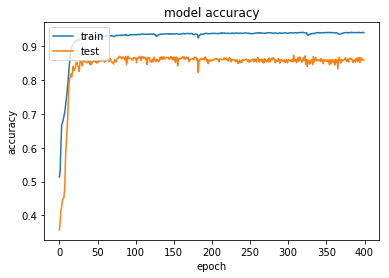

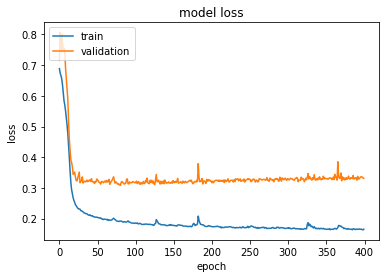

In [5]:
# Visualize training history
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 8
numpy.random.seed(seed)

dataset = numpy.loadtxt("k_DNN_train.csv", delimiter=",")

# split into input (X) and output (Y) variables
X = dataset[:,1:68]
Y = dataset[:,0]

X_val = dataset[:, 1:68]
Y_val = dataset[: , 0]
# create model
model = Sequential()
# model.add(input_shape=(80,))
model.add(Dense(80, input_dim=67,  kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(160, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(80, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint
filepath="DNN.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Fit the model
history = model.fit(X, Y, validation_split=0.2, epochs=400, batch_size=10000, callbacks = callbacks_list, verbose=0, initial_epoch=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Fit the model
history = model.fit(X, Y, validation_split=0.2, epochs=1000, batch_size=10000, callbacks = callbacks_list, verbose=0, initial_epoch=800)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### Test (With BRCA- No Tissue)

Created model and loaded weights from file
19648/20000 [============================>.] - ETA: 0s 

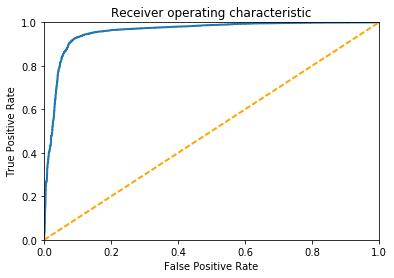

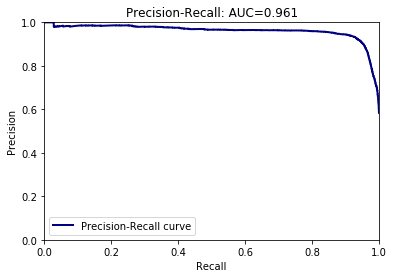

In [6]:
dataset_test = numpy.loadtxt("k_DNN_test.csv", delimiter=",")
# split into input (X) and output (Y) variables
X_test = dataset_test[:,1:68]
Y_test = dataset_test[:,0]


# load weights
model.load_weights("DNN.weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Created model and loaded weights from file")


# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X_test, Y_test, verbose=1)

y_score = model.predict_proba(X_test)

print(model.metrics_names)
print(scores)

roc(Y_test, y_score)
pr(Y_test, y_score)


In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')